In [1]:
!nvidia-smi

Mon Jul 15 05:05:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Let's make sure that we have access to GPU

In [2]:
!pip install -q supervision ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 71.3 MB/s eta 0:00:00


In [3]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

In [4]:
SOURCE_VIDEO_PATH = "vehicle_sample.mp4"
TARGET_VIDEO_PATH = "vehicles-result.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "yolov8x.pt"
MODEL_RESOLUTION = 1280

In [6]:
SOURCE = np.array([
    [252, 257],
    [1098, 257],
    [1339, 575],
    [-65, 575]
])

TARGET_WIDTH = 250
TARGET_HEIGHT = 175

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT -1],
])

In [7]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

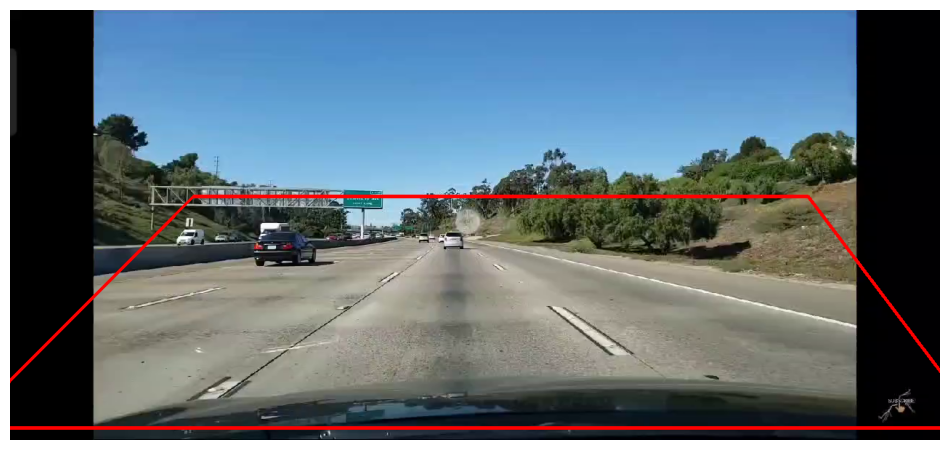

In [8]:
annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.RED, thickness=4)
sv.plot_image(annotated_frame)

In [9]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [10]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

In [11]:
import cv2
from collections import defaultdict, deque
from tqdm import tqdm
from ultralytics import YOLO
import supervision as sv

# Assuming MODEL_NAME, SOURCE_VIDEO_PATH, CONFIDENCE_THRESHOLD, IOU_THRESHOLD, MODEL_RESOLUTION, SOURCE, TARGET_VIDEO_PATH are defined elsewhere
# Placeholder for view_transformer, replace with actual implementation
class ViewTransformer:
    def transform_points(self, points):
        return points  # Replace with actual transformation logic

view_transformer = ViewTransformer()

def calculate_dynamic_line_thickness(resolution_wh):
    width, height = resolution_wh
    base_thickness = (width + height) / 2000  # Adjust the divisor as needed
    return max(1, int(base_thickness))

def calculate_dynamic_text_scale(resolution_wh):
    width, height = resolution_wh
    base_scale = (width + height) / 4000  # Adjust the divisor as needed
    return max(0.5, base_scale)

def calculate_ttc(distance, relative_speed):
    if relative_speed <= 0:
        return float('inf')
    return distance / relative_speed

model = YOLO(MODEL_NAME)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# tracer initiation
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_activation_threshold=CONFIDENCE_THRESHOLD
)

# annotators configuration
thickness = calculate_dynamic_line_thickness(video_info.resolution_wh)
text_scale = calculate_dynamic_text_scale(video_info.resolution_wh)

box_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

polygon_zone = sv.PolygonZone(
    polygon=SOURCE
)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# Assuming speed of your car
your_car_speed = 60  # in m/s, adjust as needed

# open target video
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over source video frame
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # filter out detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]

        # refine detections using non-max suppression
        detections = detections.with_nms(IOU_THRESHOLD)

        # pass detection through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

        # calculate the detections position inside the target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # format labels
        labels = []
        for tracker_id in detections.tracker_id:
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"#{tracker_id}")
            else:
                # calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = (distance / time) * 3.6  # Speed in km/h
                relative_speed = your_car_speed - (speed / 3.6)  # Convert speed to m/s
                ttc = calculate_ttc(distance, relative_speed)
                labels.append(f"#Speed: {int(speed)} km/h, TTC: {ttc:.2f} sec")

        # annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

        # add frame to target video
        sink.write_frame(annotated_frame)


100%|██████████| 131M/131M [00:00<00:00, 480MB/s]
100%|██████████| 1416/1416 [03:04<00:00,  7.67it/s]
